In [16]:
import xgboost
print(xgboost.__version__)
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder


2.1.4


[0]	validation_0-rmse:2683.45304
[100]	validation_0-rmse:1335.35533
[200]	validation_0-rmse:1269.81789
[300]	validation_0-rmse:1245.91162
[400]	validation_0-rmse:1235.37043
[500]	validation_0-rmse:1230.75904
[600]	validation_0-rmse:1226.09070
[700]	validation_0-rmse:1224.67015
[800]	validation_0-rmse:1222.59342
[900]	validation_0-rmse:1221.15388
[1000]	validation_0-rmse:1220.47682
[1100]	validation_0-rmse:1219.74847
[1200]	validation_0-rmse:1219.08878
[1300]	validation_0-rmse:1218.39261
[1365]	validation_0-rmse:1218.14561


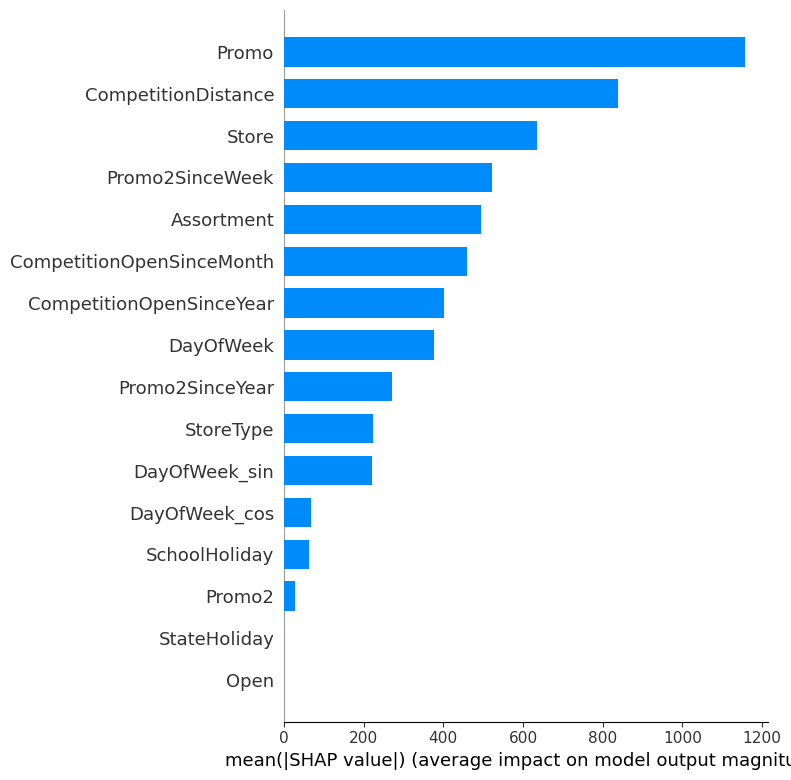

RMSE: 1218.14, RMSPE: 0.2649


In [17]:
# Load the data
data = pd.read_csv("data/preprocessed_data.csv")
data["StoreType"] = LabelEncoder().fit_transform(data["StoreType"])
data["Assortment"] = LabelEncoder().fit_transform(data["Assortment"])
data["StateHoliday"] = data["StateHoliday"].map({"0": 0, "a": 1, "b": 2, "c": 3})
data = data.drop(['PromoInterval'], axis=1, errors='ignore')
data['Date'] = pd.to_datetime(data['Date'])

# Cyclical encoding for DayOfWeek
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['DayOfWeek_sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
data['DayOfWeek_cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)

object_columns = data.select_dtypes(include=['object']).columns.tolist()
if object_columns:
    print(f"  Additional object columns found: {object_columns}")
    data = pd.get_dummies(
        data, 
        columns=object_columns, 
        drop_first=False
        )
# Prepare the data
X = data.drop(['Sales', 'Customers', 'Date'], axis=1)
y = data['Sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=50)

# Create XGBoost model with early stopping
model = xgb.XGBRegressor(
    n_estimators=10000,
    learning_rate=1,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=50,
    early_stopping_rounds=50,
    objective='reg:squarederror',
    device='cuda'
)
# Train with early stopping
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)
# Use SHAP to explain
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)
# Plot SHAP chart
shap.summary_plot(shap_values, X_val, plot_type="bar")
plt.show()
# Predict and evaluate
y_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmspe = np.sqrt(np.mean(((y_val - y_pred) / y_val) ** 2))
print(f"RMSE: {rmse:.2f}, RMSPE: {rmspe:.4f}")